In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set(style='whitegrid')
sampleSize = 10000

In [2]:
def bernoulli(p, sampleSize):
    return stats.bernoulli.rvs(p, size=sampleSize)

def binom(n, p, sampleSize):
    x = bernoulli(p, n * sampleSize)
    x = x.reshape([n, sampleSize])
    return np.sum(x, axis=0)


def poisson(mu, sampleSize):
    n = 1000 # 十分大きい数
    p = mu / n
    return binom(n, p, sampleSize)

def poisson_(mu, sampleSize):
    x = []
    while len(x) < sampleSize:
        t = 0
        n = -1
        while t <= 1:
            t += expon(1 / mu, 1)
            n += 1
        x.append(n)
    return np.array(x)

def geom(p, sampleSize):
    # この方法でも作れるが遅い。
    #x = []
    #for _ in range(sampleSize):
    #    t = 1
    #    while bernoulli(1 - p, 1):
    #        t += 1
    #    x.append(t)
    #return np.array(x)
    
    n = 1000  # ベルヌーイ分布に従うサンプルを同時にnサンプル生成する。
    x = []
    s = np.array([-1], dtype=int)
    while len(x) < sampleSize:
        x_ = bernoulli(p, n)
        x_ = np.where(x_ == 1)[0]
        x_ = np.concatenate([s, x_])
        x.extend(x_[1:] - x_[:-1])
        s = np.array([x_[-1] - n])
    return np.array(x[:sampleSize])

def nbinom(n, p, sampleSize):
    x = geom(p, sampleSize * n) - 1
    x = x.reshape([sampleSize, n])
    return np.sum(x, axis=1)

def expon(lam, sampleSize):
    p = 0.01
    x = geom(p, sampleSize)
    return x * p * lam

def gamma(alpha, lam, sampleSize):
    x = expon(lam, sampleSize * alpha)
    x = x.reshape([sampleSize, alpha])
    return np.sum(x, axis=1)

def gamma_(alpha, lam, sampleSize):
    p = 0.01  # 十分小さい数
    x = nbinom(alpha, p, sampleSize)
    return x * p * lam


def norm(mu, sigma, sampleSize):
    n = 1000 # 十分大きい数
    p = 0.5
    x = binom(n, p, sampleSize)
    sd = (n * p * (1 - p)) ** 0.5
    x = (x - n * p) / sd * sigma + mu
    return x

def chi2(df, sampleSize):
    x = norm(0, 1, sampleSize * df) ** 2
    x = x.reshape([sampleSize, df])
    return np.sum(x, axis=1)

def gamma__(alpha, lam, sampleSize):
    df = int(np.round(alpha * 2))
    x = chi2(1, sampleSize * df)
    x = x.reshape([sampleSize, df])
    x = x * lam / 2
    return np.sum(x, axis=1)

def beta(alpha, beta, sampleSize):
    x1 = gamma(alpha, 1, sampleSize)
    x2 = gamma(beta, 1, sampleSize)
    return x1 / (x1 + x2)

def uniform(sampleSize):
    return beta(1, 1, sampleSize)

def t(df, sampleSize):
    x1 = norm(0, 1, sampleSize)
    x2 = norm(0, 1, sampleSize * df) ** 2
    x2 = x2.reshape([sampleSize, df]) 
    x2 = np.sum(x2, axis=1) / df
    return x1 / x2 ** 0.5

def f(m, n, sampleSize):
    x1 = norm(0, 1, sampleSize * m) ** 2
    x1 = x1.reshape([sampleSize, m]) 
    x1 = np.sum(x1, axis=1)
    x2 = norm(0, 1, sampleSize * n) ** 2
    x2 = x2.reshape([sampleSize, n])
    x2 = np.sum(x2, axis=1)
    return (x1 / m ) / (x2 / n)

def hypergeom(M, n, N, sampleSize):
    x = []
    for _ in range(sampleSize):
        M_ = M
        N_ = N
        hitNum = 0
        for _ in range(n):
            hitFlag = bernoulli(N_ / M_, 1)
            M_ -= 1
            if hitFlag:
                hitNum += 1
                N_ -= 1
        x.append(hitNum)
    return np.array(x)

def bernoulli_(p, sampleSize):
    x = uniform(sampleSize)    
    return (x < p).astype(int)

### ベルヌーイ分布

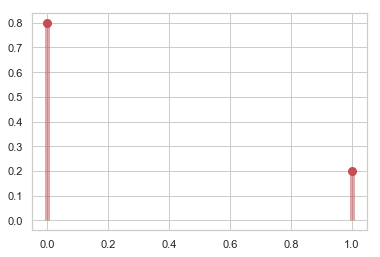

In [3]:
p = 0.2
sample = bernoulli(p, sampleSize)
x = np.arange(2)
plt.plot(x, stats.bernoulli.pmf(x, p), 'ro', ms=8)
plt.vlines(x, 0, stats.bernoulli.pmf(x, p), colors='r', lw=5, alpha=0.5)

In [4]:
def plot_descreteDitribution(sample, truePf, xmin, xmax):
    sampleSize = len(sample)
    x = np.arange(xmin, xmax + 1)
    pf = np.array([np.sum(sample == i) for i in x]) / sampleSize  # 実験で求めた分布    
    
    # 実験で求めた分布を青色でプロット
    plt.plot(x - 0.1, pf, 'bo', ms=8)
    plt.vlines(x - 0.1, 0, pf, colors='b', lw=5, alpha=0.5)

    # 真の分布を赤色でプロット
    plt.plot(x + 0.1, truePf(x), 'ro', ms=8)
    plt.vlines(x + 0.1, 0, truePf(x), colors='r', lw=5, alpha=0.5)

def plot_continuousDitribution(sample, truePf, xmin, xmax):
    sampleSize = len(sample)
    x = np.linspace(xmin, xmax, 100)

    # 実験で求めた分布を青色でプロット
    th = np.linspace(xmin, xmax, 30)
    hi = np.array([np.sum(np.logical_and(th[i] < sample, sample <= th[i + 1])) for i in range(30 - 1)]) / (sampleSize * (th[1] - th[0]))
    plt.bar((th[:-1] + th[1:]) / 2, hi, width=(th[1] - th[0]))

    # 真の分布を赤色でプロット
    plt.plot(x, truePf(x), 'r', linewidth=4)

    plt.xlim(xmin, xmax)

### 二項分布

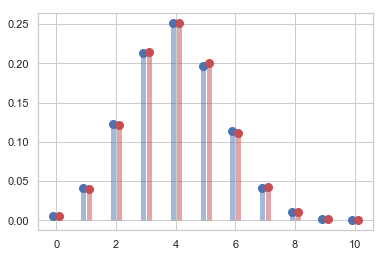

In [5]:
n = 10
p = 0.4
xmin = 0
xmax = n

sample = binom(n, p, sampleSize)
truePf = lambda x: stats.binom.pmf(x, n, p)
plot_descreteDitribution(sample, truePf, xmin, xmax)

### ポアソン分布

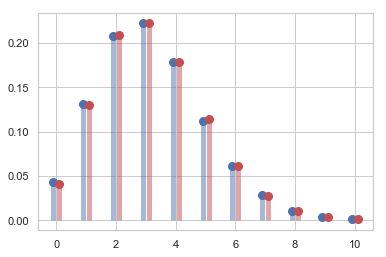

In [6]:
mu = 3.2
xmin = 0
xmax = 10

sample = poisson(mu, sampleSize)
truePf = lambda x: stats.poisson.pmf(x, mu)
plot_descreteDitribution(sample, truePf, xmin, xmax)

### ポアソン分布

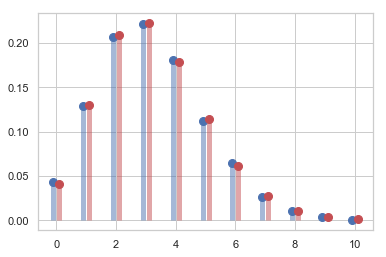

In [7]:
mu = 3.2
xmin = 0
xmax = 10

sample = poisson_(mu, sampleSize)
truePf = lambda x: stats.poisson.pmf(x, mu)
plot_descreteDitribution(sample, truePf, xmin, xmax)

### 超幾何分布

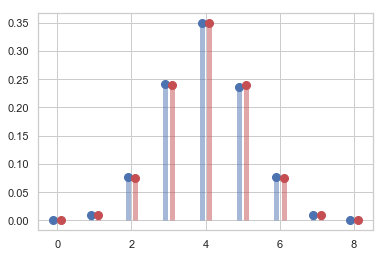

In [8]:
M = 20
N = 10
n = 8

xmin = 0
xmax = 8
sample = hypergeom(M, n, N, sampleSize)
truePf = lambda x: stats.hypergeom.pmf(x, M, n, N)
plot_descreteDitribution(sample, truePf, xmin, xmax)

### 幾何分布

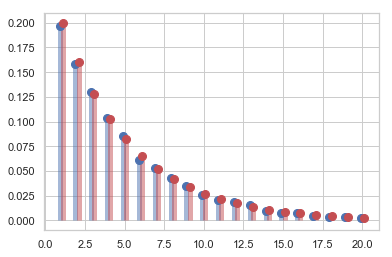

In [9]:
p = 0.2
xmin = 1
xmax = 20

sample = geom(p, sampleSize)
truePf = lambda x: stats.geom.pmf(x, p)
plot_descreteDitribution(sample, truePf, xmin, xmax)

### 負の二項分布

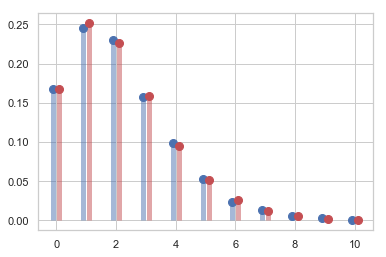

In [10]:
p = 0.7
n = 5
xmin = 0
xmax = 10

sample = nbinom(n, p, sampleSize)
truePf = lambda x: stats.nbinom.pmf(x, n, p)
plot_descreteDitribution(sample, truePf, xmin, xmax)

### 正規分布

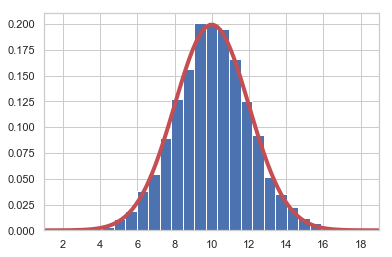

In [11]:
mu = 10
sigma = 2
xmin = 1
xmax = 19

sample = norm(mu, sigma, sampleSize)
truePf = lambda x: stats.norm.pdf(x, mu, sigma)
plot_continuousDitribution(sample, truePf, xmin, xmax)

### 指数分布

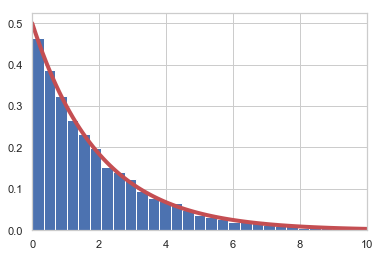

In [12]:
lam = 2
xmin = 0
xmax = 10

sample = expon(lam, sampleSize)
truePf = lambda x: stats.expon.pdf(x, scale=lam)
plot_continuousDitribution(sample, truePf, xmin, xmax)

### ガンマ分布

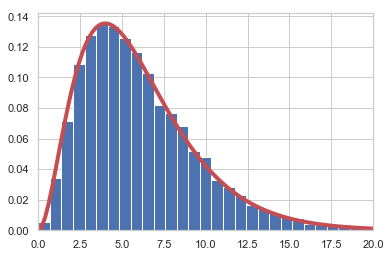

In [13]:
alpha = 3
lam = 2
xmin = 0
xmax = 20

sample = gamma(alpha, lam, sampleSize)
truePf = lambda x: stats.gamma.pdf(x, alpha, scale=lam)
plot_continuousDitribution(sample, truePf, xmin, xmax)

### ガンマ分布2

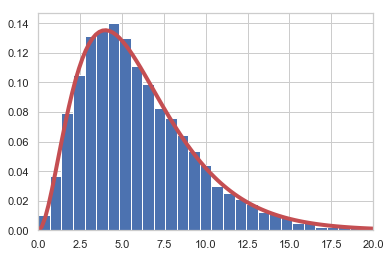

In [14]:
alpha = 3
lam = 2
xmin = 0
xmax = 20

sample = gamma_(alpha, lam, sampleSize)
truePf = lambda x: stats.gamma.pdf(x, alpha, scale=lam)
plot_continuousDitribution(sample, truePf, xmin, xmax)

### ガンマ分布3

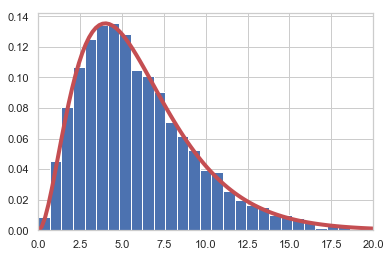

In [15]:
alpha = 3
lam = 2
xmin = 0
xmax = 20
    
sample = gamma__(alpha, lam, sampleSize)
truePf = lambda x: stats.gamma.pdf(x, alpha, scale=lam)
plot_continuousDitribution(sample, truePf, xmin, xmax)

### ベータ分布

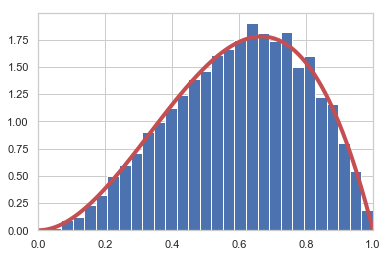

In [16]:
alpha = 3
bet = 2
xmin = 0
xmax = 1

sample = beta(alpha, bet, sampleSize)
truePf = lambda x: stats.beta.pdf(x, alpha, bet)
plot_continuousDitribution(sample, truePf, xmin, xmax)

### 一様分布

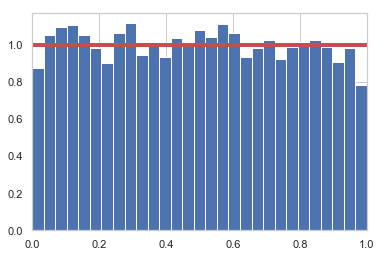

In [17]:
xmin = 0
xmax = 1

sample = uniform(sampleSize)
truePf = lambda x: stats.uniform.pdf(x)
plot_continuousDitribution(sample, truePf, xmin, xmax)

### カイ二乗分布

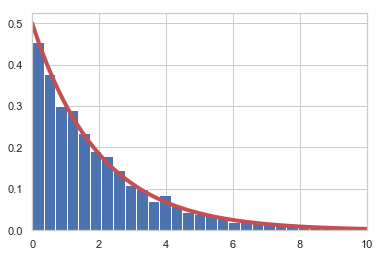

In [18]:
df = 2
xmin = 0
xmax = 10

sample = chi2(df, sampleSize)
truePf = lambda x: stats.chi2.pdf(x, df)
plot_continuousDitribution(sample, truePf, xmin, xmax)

### t分布

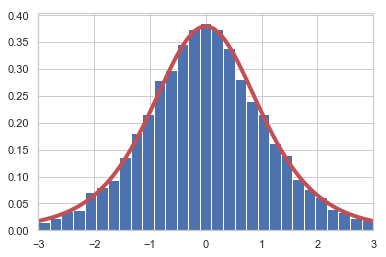

In [19]:
df = 5
xmin = -3
xmax = 3

sample = t(df, sampleSize)
truePf = lambda x: stats.t.pdf(x, df)
plot_continuousDitribution(sample, truePf, xmin, xmax)

### F分布

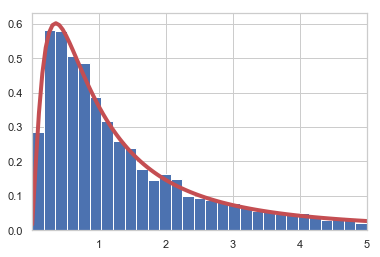

In [20]:
m = 5
n = 3
xmin = 0.01
xmax = 5

sample = f(m, n, sampleSize)
truePf = lambda x: stats.f.pdf(x, m, n)
plot_continuousDitribution(sample, truePf, xmin, xmax)

# ベルヌーイ分布

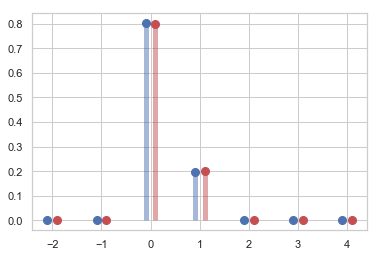

In [21]:
p = 0.2
xmin = -2
xmax = 4

sample = bernoulli_(p, sampleSize)
truePf = lambda x: stats.bernoulli.pmf(x, p)
plot_descreteDitribution(sample, truePf, xmin, xmax)